# Import thư viện cần thiết

In [1]:
import os
import sys
import time
import tarfile
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection, johnson_lindenstrauss_min_dim
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.utils import shuffle

# Tắt warning chiều dữ liệu để output sạch
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['figure.figsize'] = (20, 10)
np.random.seed(42)


# Setup dataset

In [2]:
def safe_extract_tar(filepath, extract_path):
    if os.path.exists(extract_path): shutil.rmtree(extract_path)
    with tarfile.open(filepath, "r:gz") as tar:
        if sys.version_info >= (3, 12): tar.extractall(path=extract_path, filter='data')
        else: tar.extractall(path=extract_path)

def load_mnist(filepath='mnist_in_csv.gz'):
    """
    5.1.1 Image Normalization: Min-Max scaling to [0, 1]
    """
    print(f"\n[Loader] Loading MNIST...")
    try:
        df = pd.read_csv(filepath, compression='gzip')
        # Normalize features: x_norm = x_raw / 255.0
        X = df.iloc[:, 1:].values.astype(np.float32) / 255.0
        X = shuffle(X, random_state=42)
        return X, "MNIST"
    except Exception as e: 
        print(f"Err MNIST: {e}")
        return None, None

def load_20news(filepath='20news-bydate.tar.gz'):
    """
    5.1.2 Text Vectorization: TF-IDF, min_df=2, no hard cap
    """
    print(f"\n[Loader] Loading 20News...")
    extract_path = "./temp_20news_ul"
    try:
        safe_extract_tar(filepath, extract_path)
        subdirs = [os.path.join(extract_path, d) for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
        target_dir = next((d for d in subdirs if 'train' in d), subdirs[0])
        data = load_files(target_dir, encoding='latin1')
        
        # Exact setup: min_df=2, no max_features constraint
        vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
        X = vectorizer.fit_transform(data.data)
        return X, "20Newsgroups"
    except Exception as e: 
        print(f"Err 20News: {e}")
        return None, None

def load_ecommerce(filepath='ecommerce.gz'):
    """
    5.1.2 Text Vectorization: TF-IDF, max_features=10,000, drop missing
    """
    print(f"\n[Loader] Loading Ecommerce...")
    try:
        df = pd.read_csv(filepath, compression='gzip', encoding='ISO-8859-1')
        
        # Drop rows with missing descriptions
        df = df.dropna(subset=['Description'])
        
        # Exact setup: max_features=10,000
        vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
        X = vectorizer.fit_transform(df['Description'].astype(str))
        
        return X, "Ecommerce"
    except Exception as e: 
        print(f"Err Ecommerce: {e}")
        return None, None

def collect_errors(X_orig, X_proj):
    # 5.2 Sparse Handling: Convert to dense ONLY before calculation
    if sparse.issparse(X_orig): X_orig = X_orig.toarray()
    
    d_orig = euclidean_distances(X_orig); d_proj = euclidean_distances(X_proj)
    idx = np.triu_indices(d_orig.shape[0], k=1)
    dist_o = d_orig[idx]; dist_p = d_proj[idx]
    
    valid = dist_o > 1e-6
    if np.sum(valid) == 0: return np.array([])
    return np.abs(dist_p[valid] / dist_o[valid] - 1.0)

# Utility & Theory

In [3]:
def h_bennett(u):
    if u <= -1: return float('inf')
    return (1 + u) * np.log(1 + u) - u

def calculate_m_bennett(n, epsilon, delta, density):
    u = epsilon / density
    bennett_val = h_bennett(u)
    if bennett_val < 1e-12: return johnson_lindenstrauss_min_dim(n, eps=epsilon)
    m = np.log(2/delta) / ((epsilon**2 / 2) * bennett_val)
    return int(np.ceil(m))

def estimate_ram(n_components, n_features, density, method="GRP"):
    if method == "GRP": return (n_components * n_features * 8) / (1024**2)
    else: 
        nnz = int(n_components * n_features * density)
        return (nnz * 12 + (n_components + 1) * 4) / (1024**2)

# Evaluation

In [4]:

def run_evaluation_suite(datasets):
    print("\n" + "="*50 + "\nPHASE 1: EVALUATION (Dynamic k)\n" + "="*50)
    stats = []; scatter_data = {}
    eps = 0.1
    
    # 5.2 Sampling Strategy: Limit N = 5,000
    SAMPLE_SIZE = 5000
    
    for X, name in datasets:
        n, d = X.shape
        k_jl = johnson_lindenstrauss_min_dim(n, eps=eps)
        k = min(k_jl, d)
        
        print(f">>> Processing {name} (N={n}, d={d}) -> Calculated k={k}")
        
        # Sampling
        actual_sample = min(SAMPLE_SIZE, n)
        idx = np.random.choice(n, actual_sample, replace=False)
        X_sample = X[idx]

        # 1. GRP
        t0 = time.time()
        grp = GaussianRandomProjection(n_components=k, random_state=42)
        if d > 5000: 
            grp.fit(X[:200].toarray()) # Sim fitting time
            t_grp = (time.time() - t0) * (n/200)
            X_grp = grp.transform(X_sample.toarray() if sparse.issparse(X_sample) else X_sample)
        else:
            grp.fit(X); t_grp = time.time() - t0
            X_grp = grp.transform(X_sample.toarray() if sparse.issparse(X_sample) else X_sample)
            
        err_grp = collect_errors(X_sample, X_grp)
        mem_grp = estimate_ram(k, d, 1.0, "GRP")

        # 2. SRP
        t0 = time.time()
        srp = SparseRandomProjection(n_components=k, density='auto', random_state=42)
        srp.fit(X); t_srp = time.time() - t0
        X_srp = srp.transform(X_sample)
        err_srp = collect_errors(X_sample, X_srp)
        
        actual_density = 1 / np.sqrt(d)
        
        stats.append({"Dataset": name, "Method": "GRP", "Time": t_grp, "Memory": mem_grp, "Mean Error": np.mean(err_grp), "Max Error": np.max(err_grp)})
        stats.append({"Dataset": name, "Method": "SRP", "Time": t_srp, "Memory": estimate_ram(k, d, actual_density, "SRP"), "Mean Error": np.mean(err_srp), "Max Error": np.max(err_srp)})
        scatter_data[name] = {"GRP": err_grp, "SRP": err_srp, "k": k, "d": d, "N": n}

    return pd.DataFrame(stats), scatter_data


# Ablation 

In [5]:
def run_ablation_suite(datasets):
    print("\n" + "="*50 + "\nPHASE 2: FULL ABLATION (Density, Convergence, Scalability)\n" + "="*50)
    eps = 0.1; delta = 0.05
    # Use consistent sampling size for Ablation
    ABLATION_SAMPLE = 2000 
    
    # 1. Density (Ecommerce)
    print(">>> ABLATION 1: Density vs Theory (Ecommerce)")
    abl_dens = []
    try:
        X_ecom = [d[0] for d in datasets if d[1]=="Ecommerce"][0]
        n, d = X_ecom.shape
        X_sample = X_ecom[:ABLATION_SAMPLE]
        k_fixed = min(johnson_lindenstrauss_min_dim(n, eps=eps), d)
        densities = [0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
        for p in densities:
            m_theory = calculate_m_bennett(n, eps, delta, p)
            srp = SparseRandomProjection(n_components=k_fixed, density=p, random_state=42)
            srp.fit(X_sample)
            errs = collect_errors(X_sample, srp.transform(X_sample))
            abl_dens.append({"Density": p, "Theory_m": m_theory, "Max Error": np.max(errs)})
    except: print("Skipping Ablation 1")

    # 2. Convergence k (MNIST) - Implements 5.4 Projection Loop
    print(">>> ABLATION 2: Convergence of k (MNIST)")
    abl_conv = []
    try:
        X_mnist = [d[0] for d in datasets if d[1]=="MNIST"][0]
        d_mnist = X_mnist.shape[1]
        k_range = [k for k in [100, 200, 300, 500, 700] if k < d_mnist]
        X_sample_m = X_mnist[:ABLATION_SAMPLE]
        for k in k_range:
            grp = GaussianRandomProjection(n_components=k, random_state=42)
            grp.fit(X_sample_m)
            abl_conv.append({"k": k, "Method": "GRP", "Max Error": np.max(collect_errors(X_sample_m, grp.transform(X_sample_m)))})
            srp = SparseRandomProjection(n_components=k, density='auto', random_state=42)
            srp.fit(X_sample_m)
            abl_conv.append({"k": k, "Method": "SRP", "Max Error": np.max(collect_errors(X_sample_m, srp.transform(X_sample_m)))})
    except: print("Skipping Ablation 2")

    # 3. Scalability N (20Newsgroups)
    print(">>> ABLATION 3: Scalability (20Newsgroups)")
    abl_scale = []
    try:
        X_news = [d[0] for d in datasets if d[1]=="20Newsgroups"][0]
        max_n = X_news.shape[0]
        n_range = [n for n in [500, 1000, 2000, 4000, 8000, 10000] if n <= max_n]
        k_s = 396 # Fix k
        
        for n_sub in n_range:
            X_sub = X_news[:n_sub]
            # SRP Time
            t0 = time.time()
            srp = SparseRandomProjection(n_components=k_s, density='auto')
            srp.fit(X_sub); srp.transform(X_sub)
            t_srp = time.time() - t0
            
            # GRP Time (Est for large N)
            t0 = time.time()
            grp = GaussianRandomProjection(n_components=k_s)
            grp.fit(X_sub[:min(200, n_sub)].toarray()) 
            t_grp = (time.time() - t0) * (n_sub / 200)
            
            abl_scale.append({"N": n_sub, "Method": "SRP", "Time": t_srp})
            abl_scale.append({"N": n_sub, "Method": "GRP", "Time": t_grp})
    except: print("Skipping Ablation 3")

    return pd.DataFrame(abl_dens), pd.DataFrame(abl_conv), pd.DataFrame(abl_scale)


# VISUALIZATION

In [6]:
def plot_full_report(df_res, scatter_data, df_dens, df_conv, df_scale):
    # 1. SCATTER PLOTS (Evaluation)
    for name, data in scatter_data.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
        viz_sample = min(2000, len(data["GRP"]))
        idx_g = np.random.choice(len(data["GRP"]), viz_sample, replace=False)
        idx_s = np.random.choice(len(data["SRP"]), viz_sample, replace=False)
        
        # GRP
        axes[0].scatter(np.arange(len(idx_g)), data["GRP"][idx_g], c='blue', alpha=0.4, s=15)
        axes[0].set_title(f"GRP on {name}", fontweight='bold', color='darkblue')
        axes[0].axhline(0.1, c='green', ls='--', label='Target ε=0.1')
        
        # SRP
        axes[1].scatter(np.arange(len(idx_s)), data["SRP"][idx_s], c='red', alpha=0.4, s=15)
        axes[1].set_title(f"SRP on {name}", fontweight='bold', color='darkred')
        axes[1].axhline(0.1, c='green', ls='--', label='Target ε=0.1')
        
        info = f"Dataset: {name}\nN={data['N']}, d={data['d']}\nCalculated k={data['k']}"
        fig.text(0.5, 0.92, info, ha='center', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="gray"))
        plt.tight_layout(rect=[0, 0, 1, 0.88]); plt.show()

    # 2. RESOURCES & ERRORS
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    sns.barplot(data=df_res, x="Dataset", y="Time", hue="Method", ax=axes[0,0], palette=["blue", "red"])
    axes[0,0].set_yscale('log'); axes[0,0].set_title("Time Efficiency (Log Scale)")
    
    sns.barplot(data=df_res, x="Dataset", y="Memory", hue="Method", ax=axes[0,1], palette=["blue", "red"])
    axes[0,1].set_yscale('log'); axes[0,1].set_title("Memory Footprint (Log Scale)")
    
    sns.barplot(data=df_res, x="Dataset", y="Mean Error", hue="Method", ax=axes[1,0], palette=["blue", "red"])
    axes[1,0].set_title("Mean Error (Expectation)"); axes[1,0].axhline(0.1, c='k', ls='--')
    
    sns.barplot(data=df_res, x="Dataset", y="Max Error", hue="Method", ax=axes[1,1], palette=["blue", "red"])
    axes[1,1].set_title("Max Error (Worst Case)"); axes[1,1].axhline(0.1, c='k', ls='--')
    plt.tight_layout(); plt.show()

    # 3. ABLATION PLOTS
    if not df_dens.empty:
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax1.set_xscale('log'); ax1.set_xlabel('Density (p)')
        ax1.set_ylabel('Theoretical m (Bennett)', color='green')
        ax1.plot(df_dens['Density'], df_dens['Theory_m'], 'g--o', label='Bennett Theory')
        ax2 = ax1.twinx(); ax2.set_ylabel('Empirical Max Error', color='red')
        ax2.plot(df_dens['Density'], df_dens['Max Error'], 'r-x', label='Max Error')
        plt.title("Ablation 1: Density vs Theory (Ecommerce)"); plt.show()
    
    if not df_conv.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_conv, x="k", y="Max Error", hue="Method", marker='o', palette=["blue", "red"])
        plt.title("Ablation 2: Convergence Rate (MNIST)"); plt.ylabel("Max Error"); plt.show()
    
    if not df_scale.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_scale, x="N", y="Time", hue="Method", marker='o', palette=["red", "blue"])
        plt.title("Ablation 3: Scalability O(N) (20Newsgroups)"); plt.ylabel("Time (s)"); plt.show()


# Main


[Loader] Loading MNIST...

[Loader] Loading 20News...

[Loader] Loading Ecommerce...

PHASE 1: EVALUATION (Dynamic k)
>>> Processing MNIST (N=60000, d=784) -> Calculated k=784
>>> Processing 20Newsgroups (N=11314, d=56126) -> Calculated k=8000
>>> Processing Ecommerce (N=540455, d=2200) -> Calculated k=2200

PHASE 2: FULL ABLATION (Density, Convergence, Scalability)
>>> ABLATION 1: Density vs Theory (Ecommerce)
>>> ABLATION 2: Convergence of k (MNIST)
>>> ABLATION 3: Scalability (20Newsgroups)


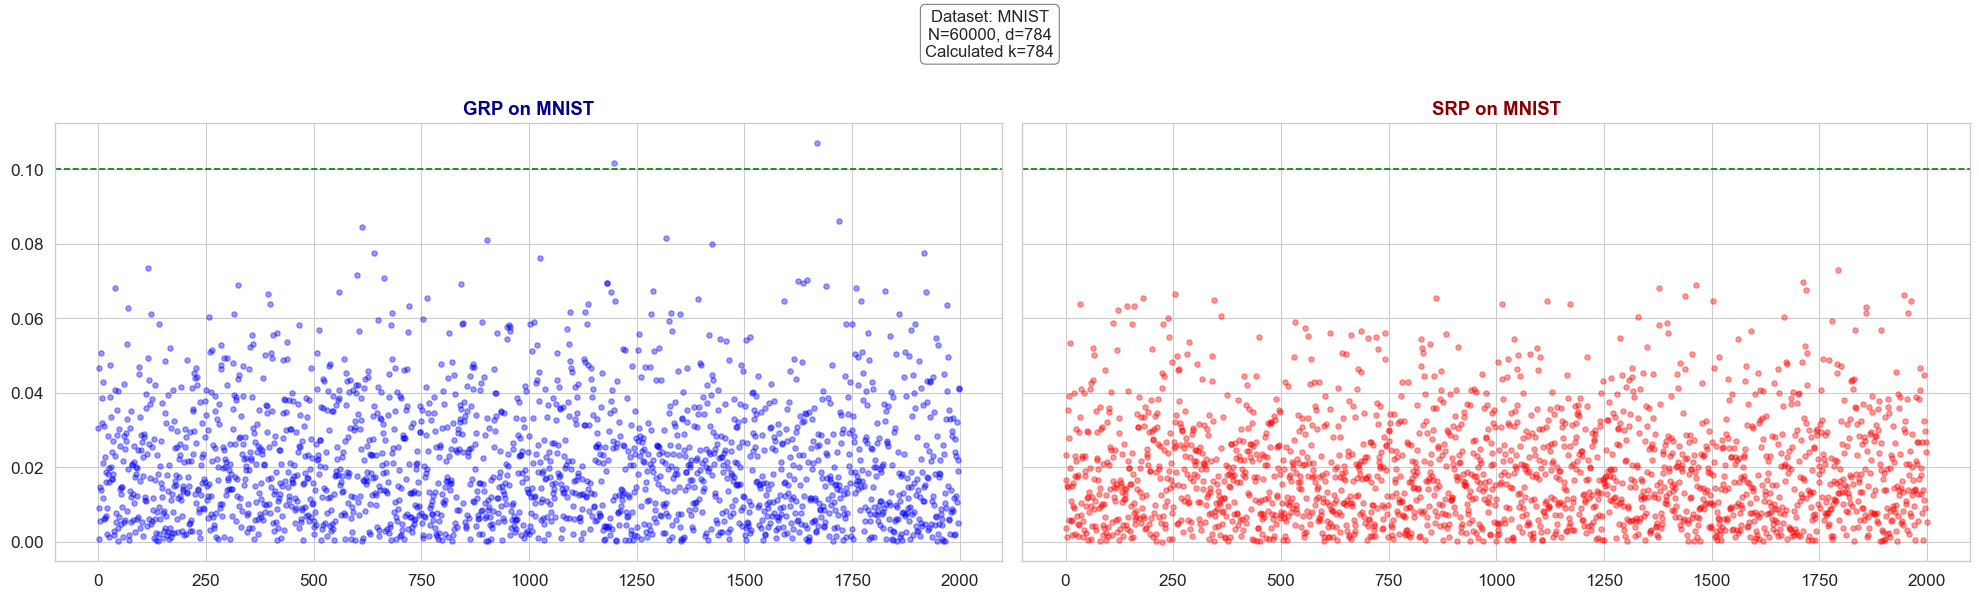

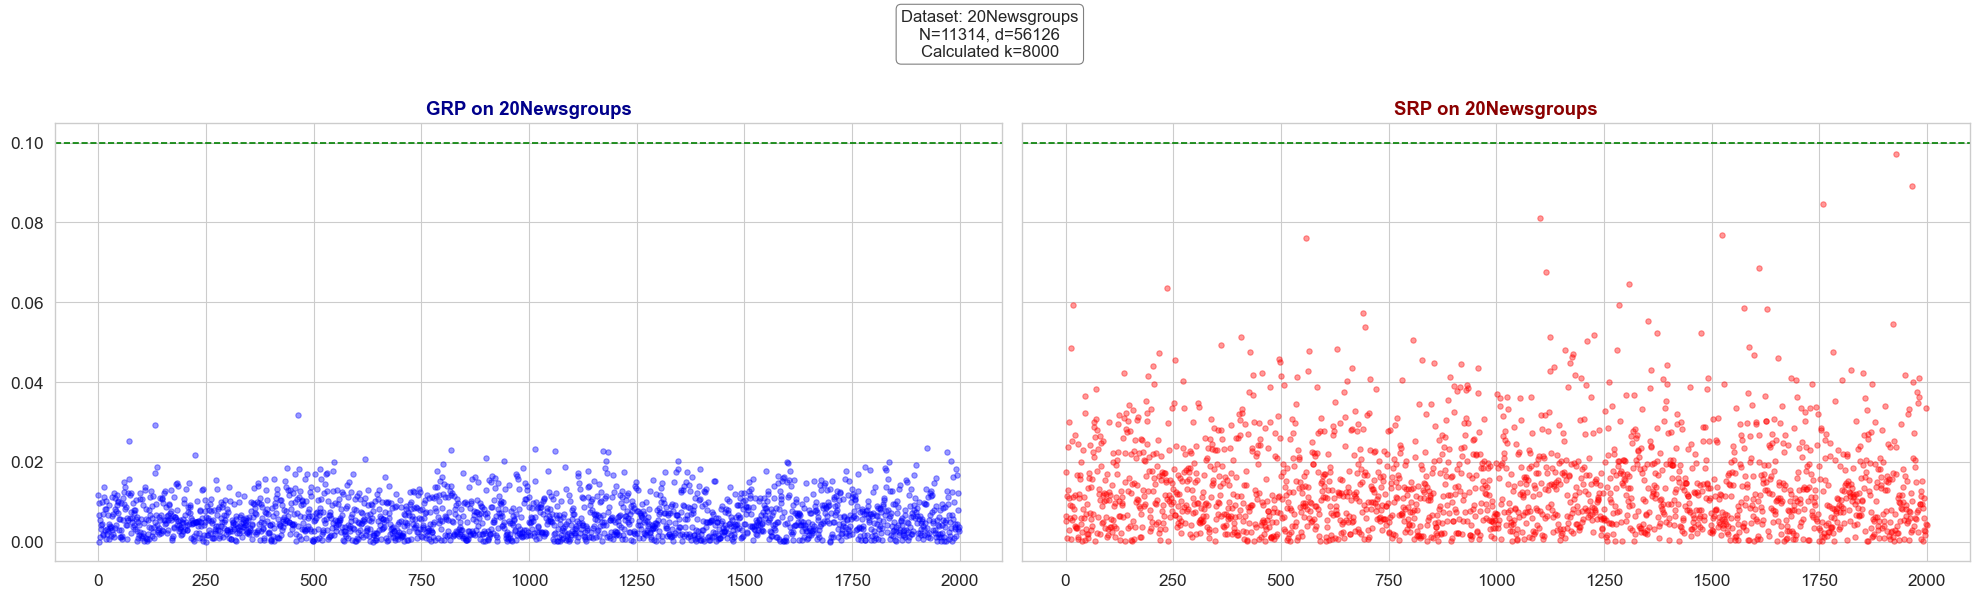

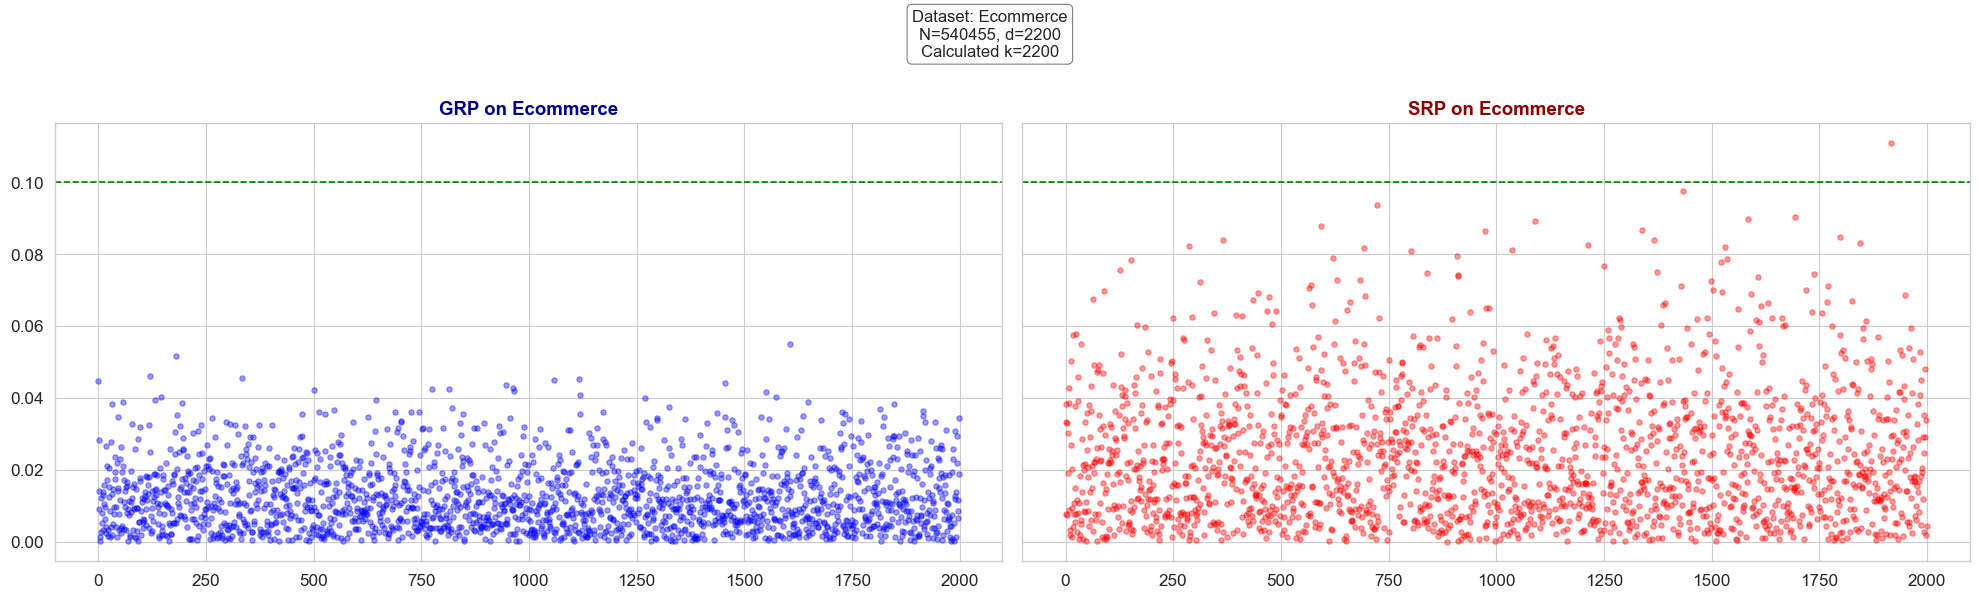

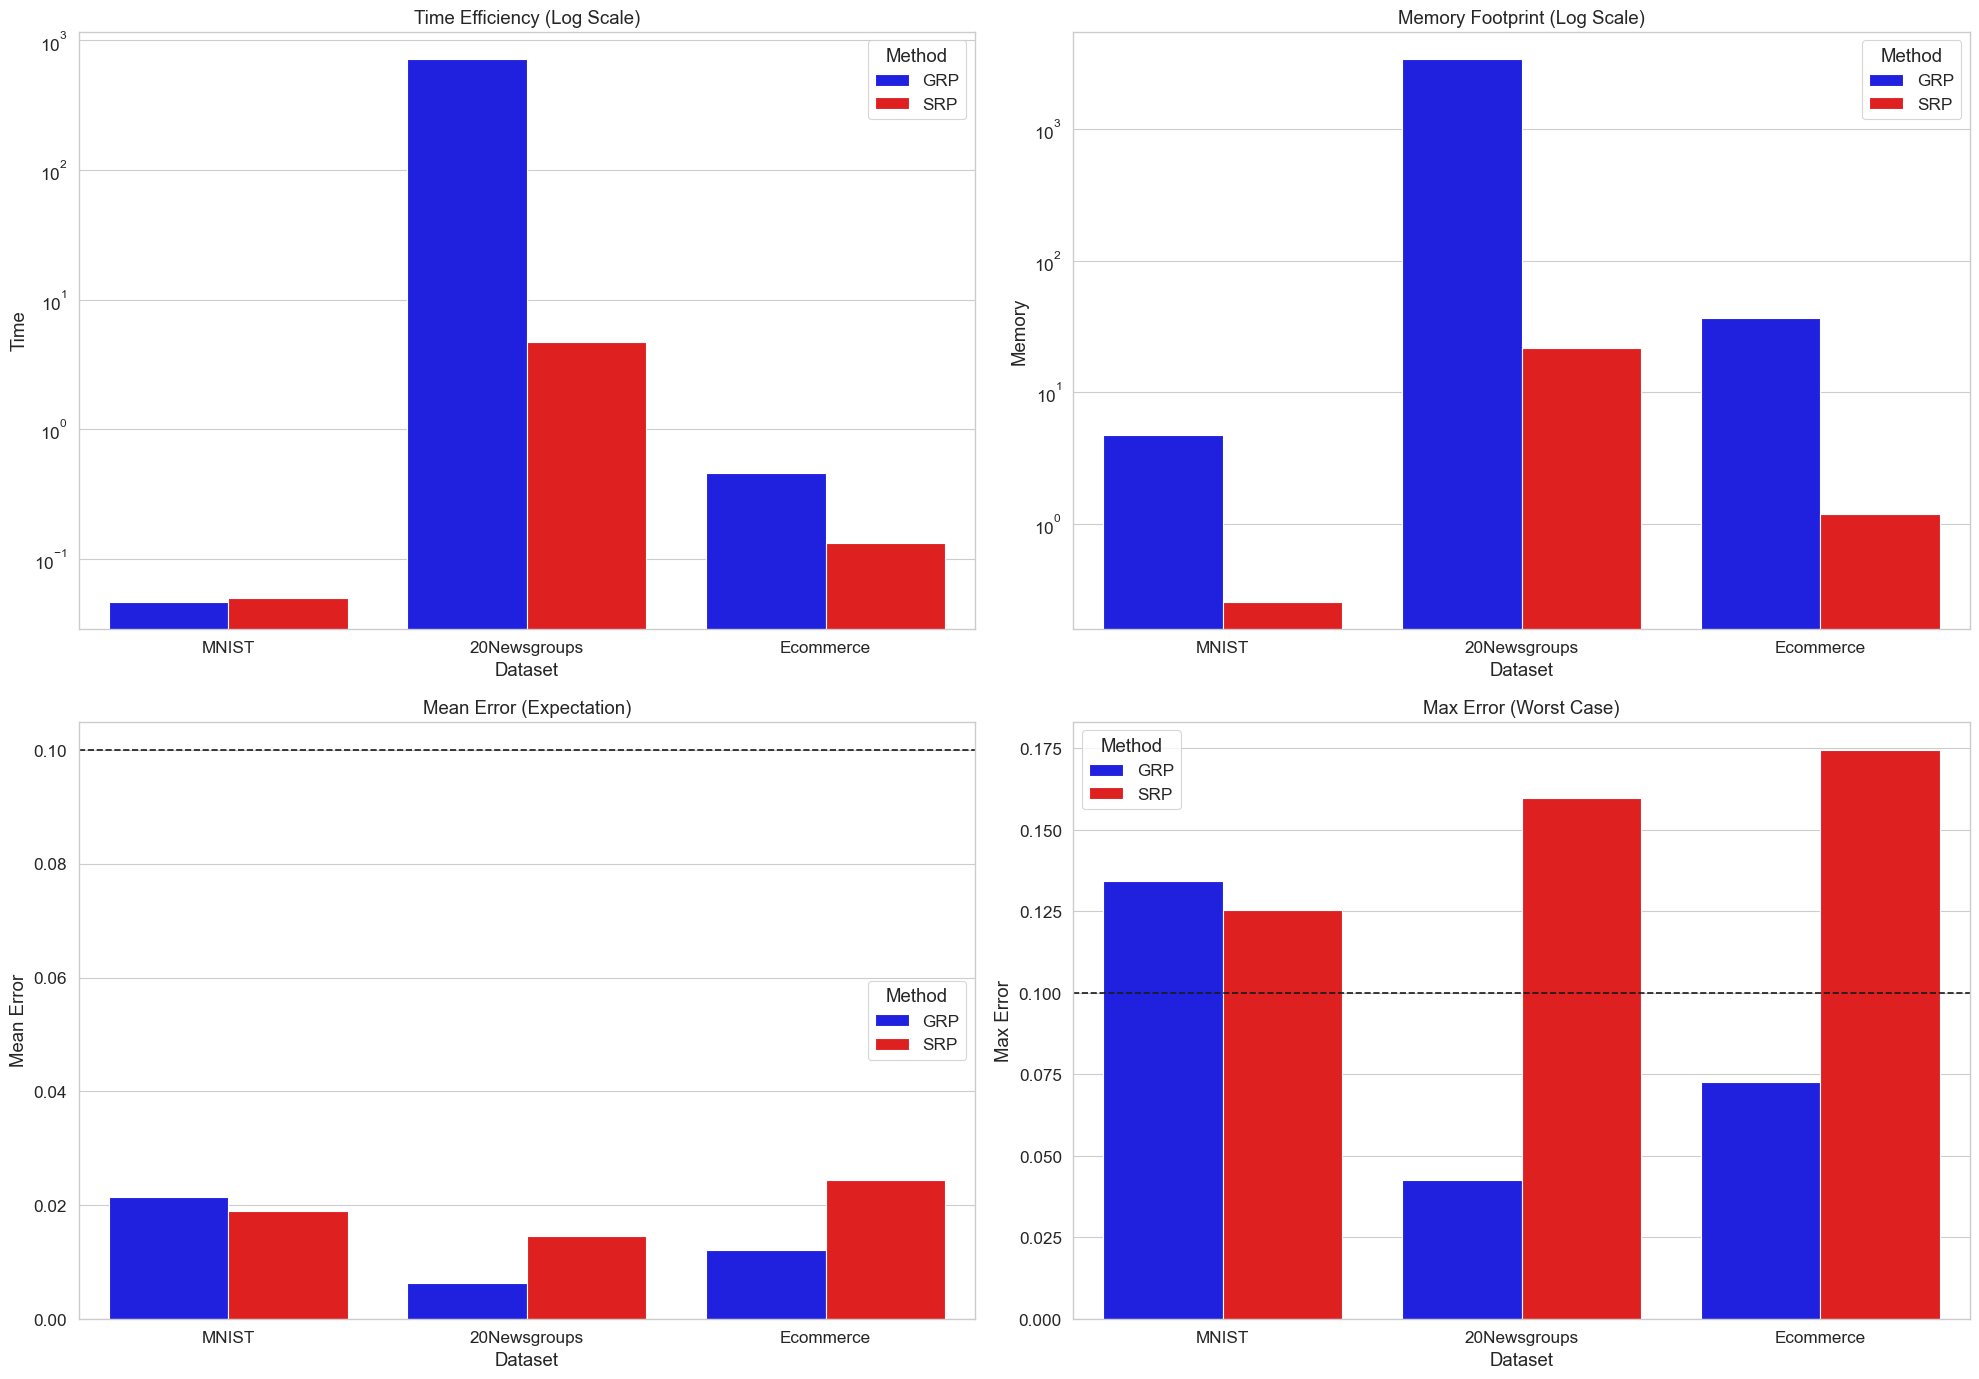

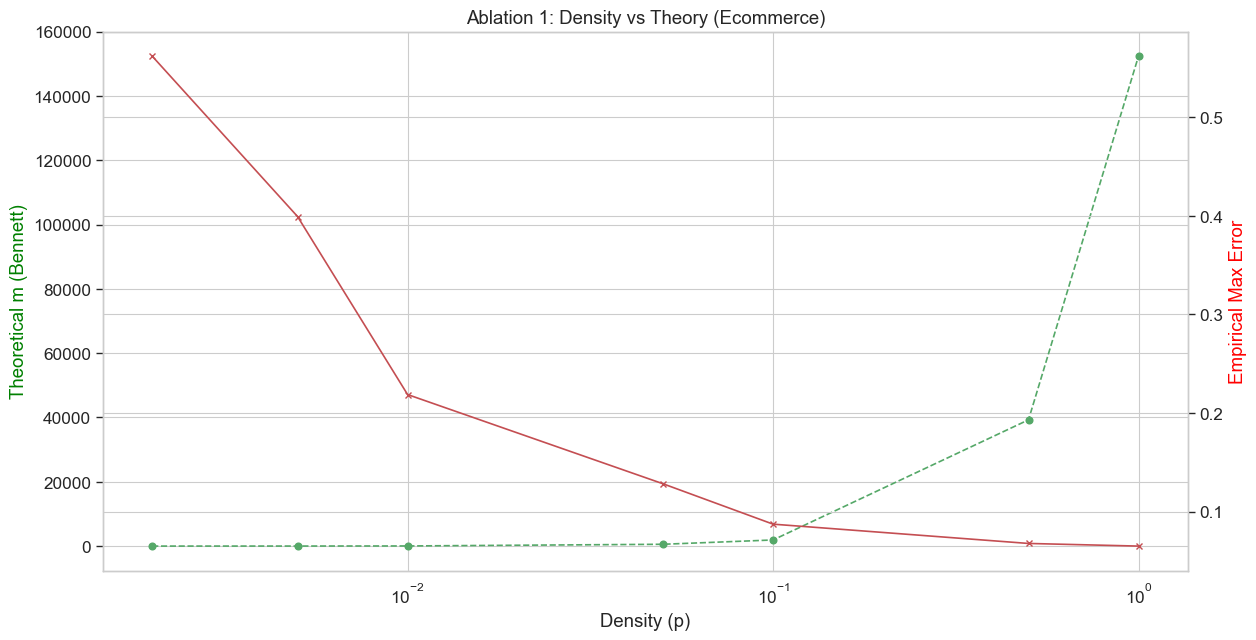

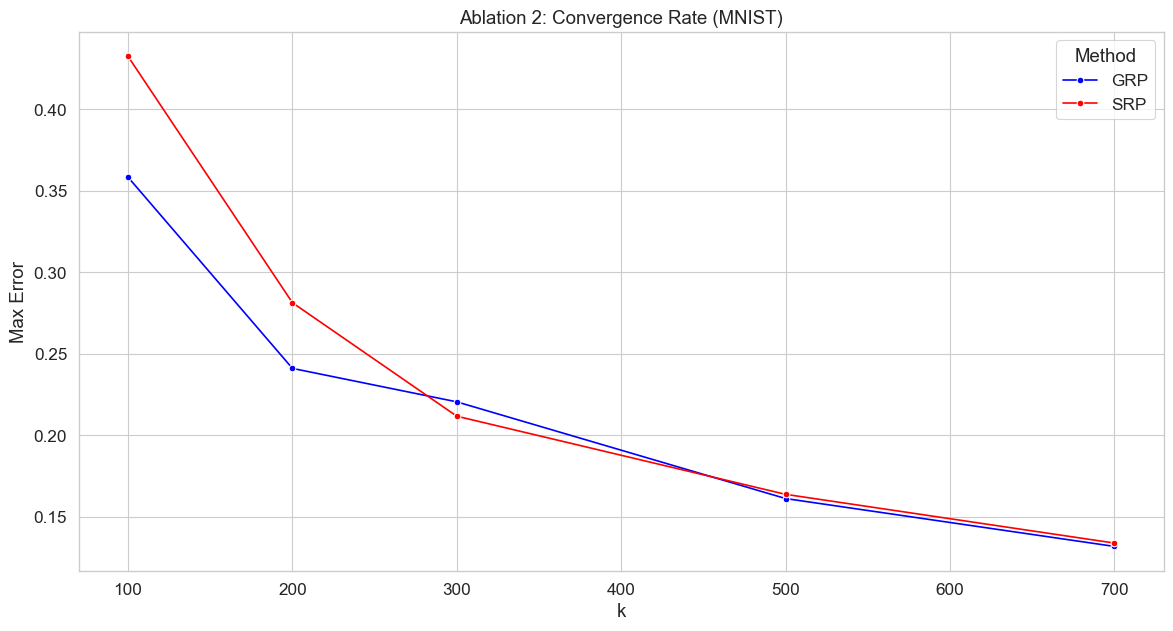

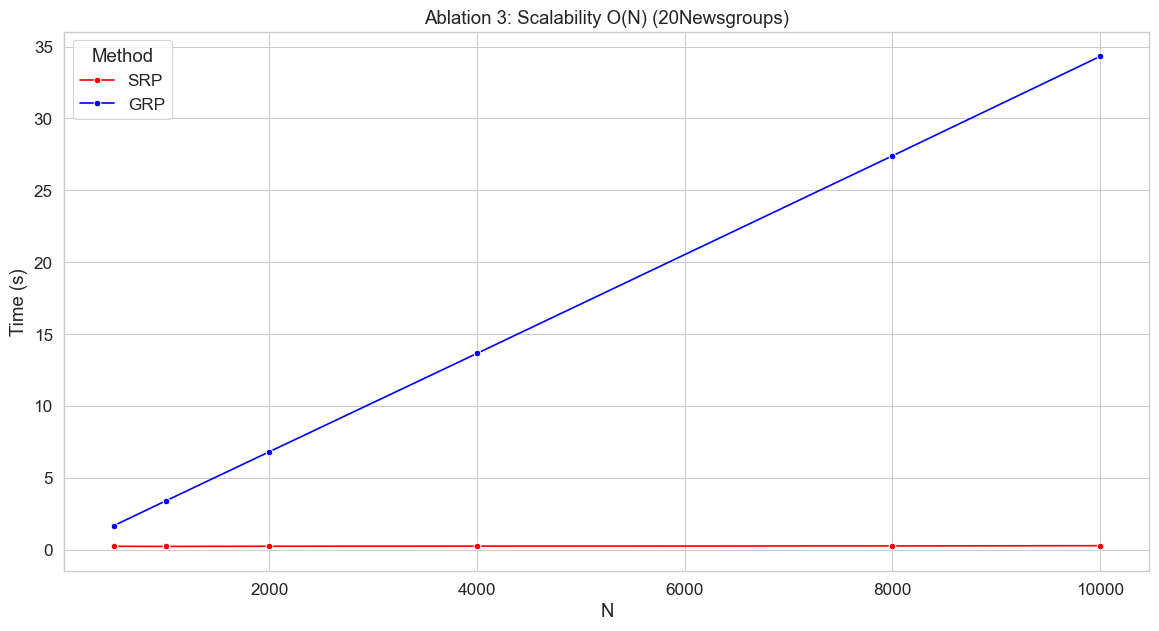

In [7]:
if __name__ == "__main__":
    ds = []
    x1,n1 = load_mnist(); 
    if x1 is not None: ds.append((x1,n1))
    x2,n2 = load_20news(); 
    if x2 is not None: ds.append((x2,n2))
    x3,n3 = load_ecommerce(); 
    if x3 is not None: ds.append((x3,n3))
    
    if ds:
        df_res, scatter_data = run_evaluation_suite(ds)
        df_dens, df_conv, df_scale = run_ablation_suite(ds)
        plot_full_report(df_res, scatter_data, df_dens, df_conv, df_scale)